## NEWS OR NOISE?
> "News is a time-honored source for investment information, and there is more of it than ever before, more than a person can handle” - Leinweber (2009)"

Our Thesis evaluated how Natural Language Processing (NLP) can reflect a firm’s course of events using firm-specific news and whether it can generate predictive content of stock returns for three Danish firms, Vestas, Novo, and Maersk. We followed an infrequently applied methodology and investigated firm-specific corpora, consisting of 20,287, 11,056, and 12,791 texts for the firms, respectively. The texts are published by Børsen, Jyllands-Posten, and Ritzau, within a time frame from primo 2001 to ultimo 2020, stretching across three recessions.

We found that firm-specific news possess great strength towards reflecting a firm’s course of events and contained predictive content towards stock return signs. We identified no adherent combination of estimators, variables, or testing intervals leading to superior results. This indicates that our methodology requires tailored firm-specific models to maximize value extraction. The study’s results should be seen in the light of its sparse data foundation, as the average word count per text is 27, with a lower amount of texts relative to comparable studies. With this in mind, we argue the strength of our NLP models to be surprising. We motivate that future emphasis should be put upon exploring the applications of NLP models as we assess their strength to be adequate in generating value. Furthermore, we present how the individual trading strategies can constitute a robust portfolio, achieving stellar returns in an out-of-sample setting compared to benchmarks, while we select the strategies retrospectively.

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import warnings
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from functions.custom import linreg

plt.style.use('ggplot')
warnings.filterwarnings('ignore')
    
## INITIATE SCALERS
lab_enc = preprocessing.LabelEncoder()
scaler = preprocessing.StandardScaler()

## DATA
We collected data in two steps. Firstly, we retrieved the firm-specific news texts from Infomedia. The retrieval resulted in three corpora consisting of 20.287, 11.056, and 12.791 texts for Vestas, Novo, and Maersk. Secondly, the trading data consist of stock prices and trading volumes for each firm retrieved from Yahoo Finance. Our text is sparse as each article contains only 27 words on average due to limitations set by Infomedia. An example of a text:

In [2]:
snippet = pd.read_csv('data/snippet.csv', index_col=0, encoding='iso-8859-1')
print(snippet['text'].values)

['Novo dropper udviklingen af ny oral GLP-1-analog; Novo Nordisks regnskabstal var i tredje kvartal holdt nede af ekstra af- og nedskrivninger på cirka 1 mia. kr. Det skyldtes blandt andet, at..']


All texts in our corpora were in Danish, which led to many obstacles throughout the process as NLP is not widely developed in Danish compared to English. The snippet can be translated to English as: "Novo stops the development of a new oral GLP-1-analog; The financial reports of Novo Nordisk were in third quarter kept down by depreciation of about 1 billion Danish kroner. This was caused by.." 

We managed to retrieve a sufficent amount of texts from Børsen, Jyllands-Posten, and Ritzau to consitute three firm-specific corpora. We are unable to publish the full extent of our corpora per agreement with Infomedia, as this would lead to copyright infringement. Therefore, we only show how one data point looked like, while the remaining observations has to be left to imagination:

In [3]:
snippet

,company,text,source,id
date,,,,
01-11-19,Novo Nordisk A/S,Novo dropper udviklingen af ny oral GLP-1-anal...,Ritzau,e76bba23


Following this, many procedures were conducted to preprocess our text.
- Removal of punctuation
- Tokenization
- Stopword removal (We removed 292 unique words, leading to 55% reduction)
- Stemming (applied DanishStemmer of nltk)
- Term-Frequency Inverse-Document-Frequency estimations 

In conclusion, we obtained three applicable firm-specific datasets with the final dataset found below.

In [4]:
company = 'novo'
df = pd.read_csv(f'data/{company}.csv', index_col=0)
df.index = pd.to_datetime(df.index, dayfirst=True)

df.tail()

,close,adj close,volume,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,sentiment,count
date,,,,,,,,,,,,,,
2020-12-22,437.15,432.00,1817136,0.134594,0.109021,0.098113,0.088166,0.121378,0.089296,0.116462,0.124546,0.118423,2.5,2
2020-12-23,432.15,426.00,1474590,0.102209,0.120502,0.141352,0.107912,0.147259,0.085599,0.119909,0.086087,0.089171,0.5,2
2020-12-28,429.40,431.05,1167650,0.102209,0.120502,0.141352,0.107912,0.147259,0.085599,0.119909,0.086087,0.089171,0.5,0
2020-12-29,431.15,429.15,1370476,0.102209,0.120502,0.141352,0.107912,0.147259,0.085599,0.119909,0.086087,0.089171,0.5,0
2020-12-30,430.00,426.65,1680200,0.153983,0.087810,0.131371,0.110611,0.108426,0.118185,0.086905,0.111177,0.091531,0.5,2


## SENTIMENT ANALYSIS
Firstly, we explored a simple field of NLP, being sentiment analysis, to identify the optimal method for gauging the tone of texts in our domain. To capture the sentiment of firm-specific news for our companies, we utilized a combination of three lexicons:
- Danish AFINN lexicon consisting of 2.091 distinct words in our setting
- Loughran MacDonald lexicon manually translated to Danish consisting of 2.555 distinct words in our setting
- 90 additional Danish words added by us, as we deemed these words being missing, while objectively positive or negative

Objective of this section: Identify the optimal method to accurately quantify the sentiment of articles by media regarding the company.

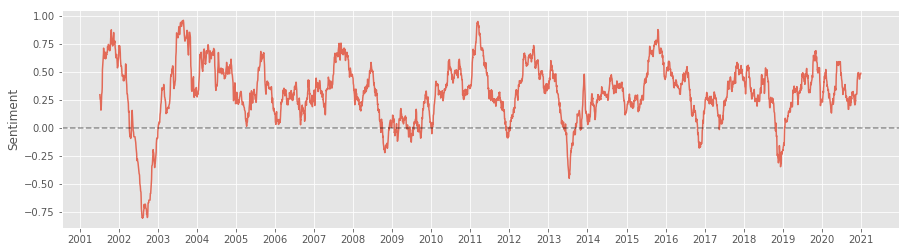

In [5]:
sent_output = df[['sentiment']]
sent_output = sent_output.set_index(df.index)

## GENERATE MOVING AVERAGE
ma = 100
sent_output_ma = sent_output.rolling(ma, min_periods=ma).mean().dropna()

## PLOT
formatter = mdates.DateFormatter('%Y')
locator = mdates.YearLocator()

fig = plt.figure(figsize=(15,4))
ax = plt.gca()
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
ax.plot(sent_output_ma.index, sent_output_ma, alpha=.8)
ax.axhline(0, color='k', alpha=0.4, linestyle='dashed')
ax.set_ylabel('Sentiment')
plt.show()

We managed to develop a method which accurately reflects the sentiment presented in financial news about the companies of interest. A snippet of our Thesis states... 
> "The analyses of the firms’ sentiment scores indicate that fluctuations in sentiment over time reflect the firms’ course of events through idiosyncratic narratives. Additionally, the analyses establish a relationship towards market factors, shown by a downward trend in sentiment during recession periods. However, differences in mean trend are not statistically significant. In contrast, the differences in variance are significantly significant for all firms at a 10%-significance level, implying that recessionary periods are more volatile than regular periods."

## TOPIC ANALYSIS
Secondly, we evaluate an alternative NLP field by estimating topic models using Latent Dirichlet Allocation (LDA) to summarize texts as topics, followed by labelling all topics with a relevant theme. Estimatations were performed using with K topics, applying α=(50/K), β=0.1, and Online Variational Bayes by Hoffmann et. al. 2010. 

Objective of this section: To identify the optimal method togenerate variables of latent topics discussed in media about the company of interest.

How does LDA work?...
> "LDA allows for topic discovery using both supervised- and unsupervised algorithms while the most popular approach is unsupervised (Liu et al., 2016). The unsupervised algorithm reduces dimensionality to k dimensions, with the objective of ”soft classification”. This reduction then allows for discovering a text’s dimensions, with dimensions being topics (Blei et al., 2003). Therefore, the unsupervised algorithm allows for discovering a latent structure in the corpus. In other words, it can extract features to build vectors and then we can use it as explanatory variable (Agrawal et al., 2018)."


> "LDA is a generative probabilistic topic model that maximizes the probability of generating a replica of the corpus. The model’s output enable one to study a latent thematic structure of a corpus (Blei, 2012). The model is estimated using a three-level hierarchical Bayesian model, which structures data in three levels; terms, topics, and texts (Blei et al., 2003). A text consist of a set of probability distributions over topics, whereas each topic is a probability distribution over terms (Borup et al., 2020)."

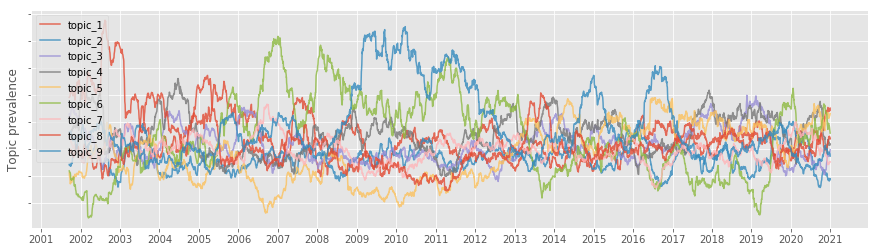

In [6]:
lda_output = df[[col for col in df.columns if 'topic' in col]].set_index(df.index)
ma = 150
lda_output_ma = lda_output.rolling(ma, min_periods=ma).mean().dropna()

## PLOT TOPICS AS TIME SERIES
i = -1
fig = plt.figure(figsize=(15,4))
ax = plt.gca()
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
for col in lda_output.columns:
    i = i + 1
    ax.plot(lda_output_ma.index, lda_output_ma.iloc[:,i], alpha=.8, label=col)
ax.set_ylabel('Topic prevalence')
ax.set_yticklabels([])
plt.legend()
plt.show()

We found that topics fluctuate over time (surprise), and that there are several types of topics present in finacial media, such as episodic, seasonal, recurrent and trending topics.

For Vestas, topics were:
- 1 = Market potential
- 2 = Orders
- 3 = Competitors
- 4 = Negative market news
- 5 = Operations
- 6 = Post-market closure price movements
- 7 = Pre-market opening price expectations
- 8 = Analyst recommendations
- 9 = Unknown (Unidentifiable)
- 10 = Pre-market opening price expectations
- 11 = Executive Management
- 12 = Financial reports

For Novo Nordisk, topics were:
- 1 = Analyst recommendations
- 2 = Financial information
- 3 = Products
- 4 = Company updates
- 5 = Executive Management
- 6 = Post-market closure price movements
- 7 = Pre-market opening price expectations
- 8 = Research and Development
- 9 = Unknown (Unidentifiable)

For Maersk, topics were:
- 1 = Analyst recommendations
- 2 = Market development
- 3 = Post-market closure price movements
- 4 = Divestments
- 5 = Unknown (Unidentifiable)
- 6 = Unknown (Unidentifiable)
- 7 = Pre-market opening price expectations
- 8 = Financial reports
- 9 = Operations
- 10 = Executive Management
- 11 = Strategy

One method of gauging the distance between topics is to visualize the topic distribution using a 3D visualization.

In [7]:
lda_raw = np.array(lda_output)
n_components = 3

## CONVERT TRADING DAYS TO PCA
lda_pca = PCA(n_components=n_components).fit(lda_output.transpose())
lda_pca = pd.DataFrame(lda_pca.components_)
lda_pca = lda_pca.transpose()

## GET MAX PROBABILITY TO VISUALIZE SIZE OF TOPIC
lda_predict_column = lda_raw.max(axis=1)
size = (1+np.array(lda_predict_column)*20)**3

## GET WHICH TOPIC WITH MAX PROBABILITY
lda_predict_value = pd.DataFrame(lda_raw).idxmax(axis=1)
labels = np.array(lda_predict_value) + 1

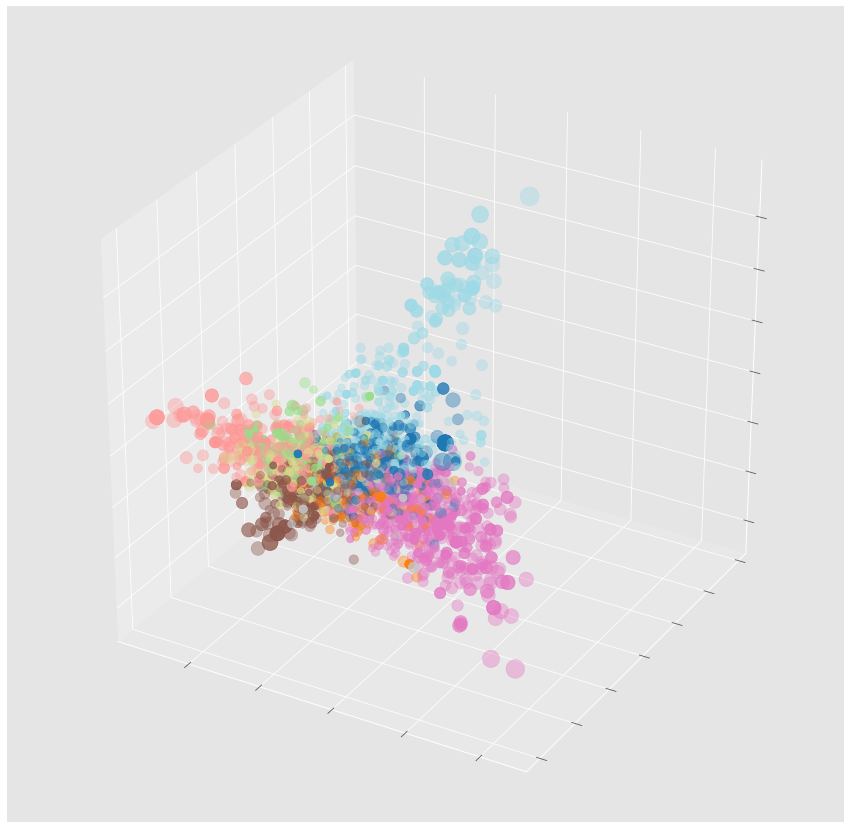

In [8]:
## PLOT
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(lda_pca[0], lda_pca[1], lda_pca[2], alpha=.4, c=labels, s=size, cmap=plt.get_cmap('tab20'))
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_zticklabels([])
plt.show()

As seen above, few topics appear distinct from the masses (identified by them being located on the outskirts). A large quantity of topics are located in the centre of the visualization, meaning that the topics possess greater similarity.

Application of LDA suffer from sensitivity towards hyperparameters. We argue, that...
> "The manual selection of hyperparameters is a significant implication of LDA. The choice of hyperparameters, particularly α and β, have a substantial effect on the optimal number of topics, and unfortunately, there is a lack of methods for solving this issue (Agrawal et al., 2018; Asuncion et al., 2009). Slight alterations in the magnitude of hyperparameters lead to notable differences in output, resulting in LDA being highly sensitive. The consequences of tuning hyperparameters is a well-known issue in theoretical ML, as tuning changes how learners apply their heuristics (Agrawal et al., 2018). Nevertheless, there is no definite method for optimizing the number of topics. Additionally, the sparse settings in this study enhance these implications. Therefore, perplexity score is the most acknowledged method to derive the optimal statistical amount of topics given α and β. However, it may not lead to the optimal number of topics relative to human interpretability. Therefore, we followed the suggestions of Hansen et al. (2018) and Blei (2012) to experiment with the number of topics. While this should lead to model improvements, undesirable subjectivity follows. Thus, we argue that this implication is not an issue for our results as we cross-validate the results with various methods. Instead, the implication merely relates to the general LDA methodology and is therefore unavoidable."

## USING NLP TOWARDS STOCK RETURNS
We used our sentiment scores and topic models to form input variables to prediction models, in addition to a combined variable using the interactions between sentiment and topics.To evaluate the power of our constructed variables, we tested two algorithms with different strenghts:
- Elastic Net (Strenghts in linear relationships)
- Random Forest (Strengths in non-linear relationships)

Furthermore, we used an explorative approach as there is No Free Lunch. We tested an exhaustive amount of combinations, with variables ranging from [Sentiment, Topic, Combined (Sentiment * Topic)], their impact captured by Long-Short and Long-Only strategies, and the impact of different lengths of input sequences towards different lengths of output sequences, called testing intervals. Through this evaluating, we idenfied one optimal strategy for each company:
- Vestas: Random Forest, Long-Only, Combined, TI(1)
- Novo: Elastic Net, Long-Only, Sentiment, TI(10)
- Maersk: Random Forest, Long-Only, Sentiment, TI(5)

We trained these algorithms to predict the future stock return sign of holding shares in the company for a period determined by the testing interval on a training set covering 2001 to 2017, and then applied a simple trading strategy to evaluate performance on our test set form 2017 to 2020.

In [9]:
def generate_signal(company, model_sel, buy_sell, variable_list, offset_list, n_components_temp, random_state, lab_enc, scaler):
    
    ## WE TRAIN ON DATA BEFORE 2017
    date_split = pd.Timestamp('2017-01-01') 

    ## SELECT INPUT VARIABLE
    row_data = []
    if input_variables == 1: model_text = 'sentiment'
    if input_variables == 1: row_data.append(model_text)
    if input_variables == 2: model_text = 'topic'
    if input_variables == 2: row_data.append(model_text)
    if input_variables == 3: model_text = 'combined'
    if input_variables == 3: row_data.append(model_text)
    
    ## MODIFY DATASET FOR TRAINING
    df_total = pd.read_csv(f'data/{company}.csv', parse_dates=True)
    df_total['date'] = pd.to_datetime(df_total['date'], dayfirst=True)
    df_total['return'] = df_total['adj close'].shift(-1) / df_total['adj close']
    df_total['sentiment'] = df_total['sentiment'].rolling(int_offset).mean()
    df_total = df_total.set_index(df_total['date'])
    
    string_total = []
    if input_variables == 1: string_total.append('sentiment')
    for h in list(range(1, n_components_temp+1, 1)):
        string_temp1 = 'topic_' + str(h)
        string_temp2 = 'combined_' + str(h)
        if input_variables == 2: string_total.append(string_temp1)
        if input_variables == 3: string_total.append(string_temp2)
        df_total[string_temp1] = df_total[string_temp1].shift(1).rolling(int_offset).mean()
        df_total[string_temp2] = df_total[string_temp1] + (df_total[string_temp1] * df_total['sentiment'].shift(1) * 2)
    string_total = sorted(string_total)
    df_total['sign'] = np.sign(df_total['adj close'].shift(-int_offset) / df_total['adj close'] - 1)
    df_total['sign'] = df_total['sign'].apply(lambda x: -1 if x == 0 else x)
    df_total = df_total.iloc[20:, :]

    ## SPLIT TO TRAIN AND TEST
    df_total_train = df_total.loc[df_total['date'] < date_split]
    df_total_test = df_total.loc[df_total['date'] >= date_split]
    df_total_test = df_total_test.set_index(df_total_test['date'], drop=True)
    
    ## SPLIT TO X AND Y
    x = pd.DataFrame(scaler.fit_transform(df_total_train[string_total]), columns=string_total)
    y = lab_enc.fit_transform(df_total_train['sign']).ravel()
    
    x_train, x_val, y_train, y_val = train_test_split(x,
                                                      y,
                                                      test_size=0.35,
                                                      random_state=random_state,
                                                      shuffle=True)
    
    x_test = pd.DataFrame(scaler.transform(df_total_test[string_total]), columns=string_total)
    y_test = lab_enc.fit_transform(df_total_test['sign']).ravel()
    
    
    ## SELECT ALGORITHM
    if model_sel == 0: 
        model = SGDClassifier(loss='log', 
                              penalty='elasticnet', 
                              learning_rate='optimal', 
                              class_weight='balanced', 
                              alpha=0.001, 
                              l1_ratio=0.5, 
                              average=True, 
                              random_state=0).fit(x_train, y_train)
    if model_sel == 1: 
        model = RandomForestClassifier(max_depth=4, 
                                       max_features=None, 
                                       class_weight='balanced', 
                                       min_samples_split=2, 
                                       random_state=0).fit(x_train, y_train)
    
    ## SAVE MODEL
    filename = f"pickle/{company}.sav"
    pickle.dump(model, open(filename, 'wb'))
    
    ## SAVE SCALER
    filename = f"scaler/{company}.pkl"
    pickle.dump(scaler, open(filename, 'wb'))
    
    ## PREDICT ON TEST SET
    y_pred = pd.DataFrame({company: model.predict(x_test)}).set_index(df_total_test.index)
    y_pred = y_pred.join(df_total['return']).iloc[:-1, :]
    y_pred = y_pred.rename({'return': company + '_return'}, axis=1)
    
    return y_pred

In [10]:
def simulate_trading(df_signal, sign_MA):
    
    ## INITITATE STARTING VALUES
    amount = 1 # OUR PORTFOLIO
    amount_bah = 1 # BUY AND HOLD
    amount_index = 1 # INDEX OF OMXC25 GROSS INDEX
    
    ## GENERATE ROLLING AVERAGES AND GET LOCATIONS OF COLUMNS
    df_signal['vestas'] = df_signal['vestas'].rolling(sign_MA).mean()
    df_signal['novo'] = df_signal['novo'].rolling(sign_MA).mean()
    df_signal['maersk'] = df_signal['maersk'].rolling(sign_MA).mean()

    df_signal['portfolio'] = float(amount)
    df_signal['bah'] = float(amount_bah)
    df_signal['index'] = float(amount_index)

    vestas_sign_pos = df_signal.columns.get_loc('vestas')
    novo_sign_pos = df_signal.columns.get_loc('novo')
    maersk_sign_pos = df_signal.columns.get_loc('maersk')

    vestas_return_pos = df_signal.columns.get_loc('vestas_return')
    novo_return_pos = df_signal.columns.get_loc('novo_return')
    maersk_return_pos = df_signal.columns.get_loc('maersk_return')

    amount_pos = df_signal.columns.get_loc('portfolio')
    bah_pos = df_signal.columns.get_loc('bah')
    index_pos = df_signal.columns.get_loc('index_return')
    index_amount_pos = df_signal.columns.get_loc('index')

    ## SET THRESHOLD FOR OPENING AND CLOSING POSITIONS
    threshold = 0.60

    ## TO INITIATE
    time_in_market = 0
    allocation = 0
    df_signal_trade = df_signal.iloc[19:, :]
    
    ## FOR EACH DAY IN TESTING SET
    for i in list(range(0, len(df_signal_trade), 1)):
        amount_bah = amount_bah * ((df_signal_trade.iat[i, vestas_return_pos] + df_signal_trade.iat[i, novo_return_pos] + df_signal_trade.iat[i, maersk_return_pos])/3)
        df_signal_trade.iat[i, bah_pos] = amount_bah

        trades_to_do = 0
        if df_signal_trade.iat[i, vestas_sign_pos] > threshold: trades_to_do = trades_to_do + 1
        if df_signal_trade.iat[i, novo_sign_pos] > threshold: trades_to_do = trades_to_do + 1
        if df_signal_trade.iat[i, maersk_sign_pos] > threshold: trades_to_do = trades_to_do + 1

        if trades_to_do > 0: allocation = 1 / trades_to_do

        amount_index = amount_index * df_signal_trade.iat[i, index_pos]
        df_signal_trade.iat[i, index_amount_pos] = amount_index

        inc1 = 0
        inc2 = 0
        inc3 = 0

        ## IF ANY TRADING SIGNAL IS INITIATED
        if trades_to_do > 0:

            # BUY VESTAS
            time_in_market = time_in_market + 1
            if df_signal_trade.iat[i, vestas_sign_pos] > threshold:
                inc1 = (amount * df_signal_trade.iat[i, vestas_return_pos]) - amount
            # BUY NOVO
            if df_signal_trade.iat[i, novo_sign_pos] > threshold:
                inc2 = (amount * df_signal_trade.iat[i, novo_return_pos]) - amount
            # BUY MAERSK
            if df_signal_trade.iat[i, maersk_sign_pos] > threshold:
                inc3 = (amount * df_signal_trade.iat[i, maersk_return_pos]) - amount
        else:
            df_signal_trade.iat[i, amount_pos] = amount

        amount = amount + (allocation*inc1) + (allocation*inc2) + (allocation*inc3)
        df_signal_trade.iat[i, amount_pos] = amount

    return df_signal_trade, time_in_market, amount

In [11]:
## GENERATE TRADING SIGNALS
company_list = ['vestas', 'novo', 'maersk']
model_list = [1, 0, 1]
buy_list = [0, 0, 0]
variable_list = [3, 1, 1]
offset_list = [1, 10, 5]
n_components_list = [12, 9, 11]
df_index = pd.read_csv(f'data/index.csv', sep=';', decimal=',', index_col=0, parse_dates=True, dayfirst=True, encoding='utf-8', usecols=['date', 'index_return'])

## FOR EACH COMPANY
for select in [0, 1, 2]:
    
    ## INITIATE VARIABLES
    company = company_list[select]
    model_sel = model_list[select]
    buy_sell = buy_list[select]
    input_variables = variable_list[select]
    int_offset = offset_list[select]
    n_components_temp = n_components_list[select]
    
    signals = generate_signal(company, model_sel, buy_sell, input_variables, int_offset, n_components_temp, 0, lab_enc, scaler)
    
    if select == 0: df_signal = signals
    if select != 0: df_signal = df_signal.join(signals)
    if select == 2: df_signal = df_signal.join(df_index).fillna(1)

## SIMULATE TRADING STRATEGY
sign_MA = 20

df_signal_trade, time_in_market, amount = simulate_trading(df_signal, sign_MA)
df_signal_trade['portfolio'] = df_signal_trade['portfolio'] - 1
df_signal_trade['bah'] = df_signal_trade['bah'] - 1
df_signal_trade['index'] = df_signal_trade['index'] - 1
df_signal_trade.tail()

,vestas,vestas_return,novo,novo_return,maersk,maersk_return,index_return,portfolio,bah,index
date,,,,,,,,,,
2020-12-21,0.5,1.039259,0.85,0.988219,0.60,0.989466,0.992809,1.599262,1.195957,0.731915
2020-12-22,0.5,0.991447,0.90,0.986111,0.60,1.009545,1.009674,1.563161,1.186516,0.748670
2020-12-23,0.5,1.060388,0.90,1.011854,0.55,0.996364,0.998193,1.593546,1.236519,0.745510
2020-12-28,0.5,0.989153,0.90,0.995592,0.50,1.003650,1.021382,1.582114,1.227867,0.782833
2020-12-29,0.5,0.986635,0.90,0.994175,0.45,0.988727,1.002157,1.567072,1.205244,0.786679


As seen above, we found that the portfolio strategy achieved a return of 156.7% from 2017 to 2020, while the BAH strategy obtained 120.5% followed by 78.7% for the index. The applied strategy is very simple. It follows:
- Initiate a position in Company X, if trading signal for Company X is > .6
- Close your existing position in Company X, if trading signal < .6

All trading signals are smoothed with a MA(20) to decrease noise. A visualization of the trading signals for the time period is found below.

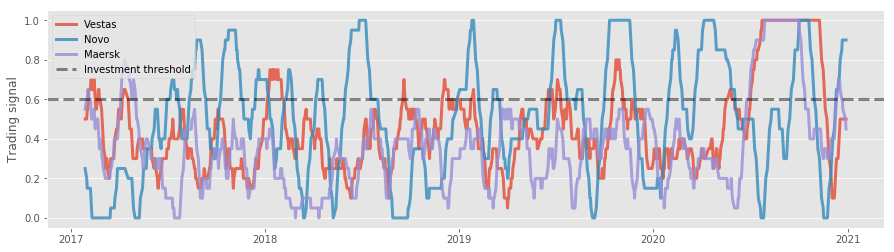

In [12]:
## VISUALIZE TRADING SIGNALS
fig = plt.figure(figsize=(15, 4))
ax = plt.gca()
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
ax.plot(df_signal_trade.index, df_signal_trade['vestas'], alpha=0.8, lw=3, label='Vestas')
ax.plot(df_signal_trade.index, df_signal_trade['novo'], alpha=0.8, lw=3, label='Novo')
ax.plot(df_signal_trade.index, df_signal_trade['maersk'], alpha=0.8, lw=3, label='Maersk')
ax.set_ylabel('Trading signal')
ax.xaxis.grid()
ax.axhline(y=0.6, color='k', linestyle='--', lw=3, alpha=0.45, label='Investment threshold')
plt.legend(loc='upper left')
plt.show()

In [13]:
## RETRIEVE STATISTICS
## CONVERT DATA TO ANNUALIZED
temp = []
temp.insert(0, {'index_return': 1, 'portfolio': 1, 'bah': 1, 'index': 1})
y_pred_annual = df_signal_trade.groupby(pd.Grouper(freq='A')).nth(-1)
y_pred_annual = pd.concat([pd.DataFrame(temp), y_pred_annual])
y_pred_annual['portfolio'] = (y_pred_annual['portfolio']+1) / (y_pred_annual['portfolio'].shift(1)+1) - 1
y_pred_annual['index'] = (y_pred_annual['index']+1) / (y_pred_annual['index'].shift(1)+1) - 1
y_pred_annual['bah'] = (y_pred_annual['bah']+1) / (y_pred_annual['bah'].shift(1)+1) - 1
y_pred_annual = y_pred_annual.dropna()

## GENERATE STATISTICS
sharpe = y_pred_annual['portfolio'].mean() / y_pred_annual['portfolio'].std()
alpha, beta = linreg(np.array(y_pred_annual['index']-1), np.array(y_pred_annual['portfolio']-1))
portfolio_in_market = round((time_in_market/len(df_signal_trade))*100, 1)

print('Sharpe-ratio:', round(sharpe, 1))
print('Alpha:', round(alpha, 1))
print('Beta:', round(beta, 1))
print('Time in market:', portfolio_in_market, '%')

Sharpe-ratio: 0.3
Alpha: 0.6
Beta: 1.4
Time in market: 46.3 %


The obtained result for the portfolio of a return of 156.7% is great seen in the light of the time in market only being 46.3% of the time. This indicates that the strategy is useful to time investments in companies, while it in this setting only had three companies to choose from being Vestas, Novo, and Maersk. A future point of research could be to see if time in market increases as the option of more companies increase.

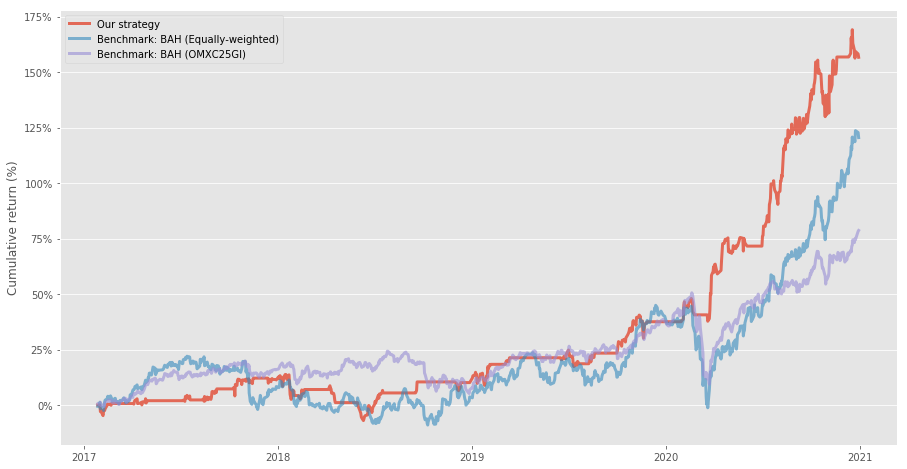

In [14]:
fig = plt.figure(figsize=(15, 8))
ax = plt.gca()
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
ax.plot(df_signal_trade.index, df_signal_trade['portfolio'], lw=3, label='Our strategy', alpha=0.8, zorder=1)
ax.plot(df_signal_trade.index, df_signal_trade['bah'], alpha=0.6, lw=3, label='Benchmark: BAH (Equally-weighted)', zorder=2)
ax.plot(df_signal_trade.index, df_signal_trade['index'], alpha=0.6, lw=3, label='Benchmark: BAH (OMXC25GI)', zorder=2)
ax.yaxis.set_major_formatter(mticks.PercentFormatter(1.0))
ax.set_ylabel('Cumulative return (%)')
ax.xaxis.grid()
plt.legend(loc='upper left')
plt.show()

Our final result: We beat both of our benchmarks in the period of the study. However, we tested almost endless of combinations of variables and timeframes to obtain this result. Additionally, no adherent combination of estimators, NLP variables, or testing intervals determined a superior trading strategy across companies. Therefore, any potential strategy has to be firm-specific, leading to the development of these to be resource-intensive.

## ROBUSTNESS
As with any study, one has to evaluate the robustness of results.
### ON TRAINING, TEST, VALIDATION SPLIT
A factor of great importance to trading results is which samples are contained in the training and validation sets. Thus, we explore the robustness of results by simulating the best performing strategies across 300 alternative random splits of validation and training.

In [15]:
result_list = []
num_iter = 300

for iter in range(num_iter):
    ## GENERATE TRADING SIGNALS
    company_list = ['vestas', 'novo', 'maersk']
    model_list = [1, 0, 1]
    buy_list = [0, 0, 0]
    variable_list = [3, 1, 1]
    offset_list = [1, 10, 5]
    n_components_list = [12, 9, 11]
    df_index = pd.read_csv(f'data/index.csv', sep=';', decimal=',', index_col=0, parse_dates=True, dayfirst=True, encoding='utf-8', usecols=['date', 'index_return'])

    ## FOR EACH COMPANY
    for select in [0, 1, 2]:

        ## INITIATE VARIABLES
        company = company_list[select]
        model_sel = model_list[select]
        buy_sell = buy_list[select]
        input_variables = variable_list[select]
        int_offset = offset_list[select]
        n_components_temp = n_components_list[select]

        signals = generate_signal(company, model_sel, buy_sell, input_variables, int_offset, n_components_temp, iter, lab_enc, scaler)

        if select == 0: df_signal = signals
        if select != 0: df_signal = df_signal.join(signals)
        if select == 2: df_signal = df_signal.join(df_index).fillna(1)

    ## SIMULATE TRADING STRATEGY
    sign_MA = 20
    df_signal_trade, time_in_market, amount = simulate_trading(df_signal, sign_MA)    
    result_list.append((amount-1)*100)
    
df_results = pd.DataFrame({'return': result_list})
mean_results = round(df_results['return'].mean(), 1)
std_results = round(df_results['return'].std(), 1)

print(f'Mean across {num_iter} simulations:', mean_results, '%')
print(f'Std. across {num_iter} simulations:', std_results)

df_results.transpose().iloc[:,:5]

Mean across 300 simulations: 178.9 %
Std. across 300 simulations: 78.8


,0,1,2,3,4
return,156.707163,194.860982,47.857891,191.713453,174.377411


We found that trading returns fluctuate across the various splits. These fluctuations are potentially caused by small sample bias, as stated by Lavrenko et al. (2000), since the training- and validation sets may not capture all causal relationships between the NLP variables and stock returns.

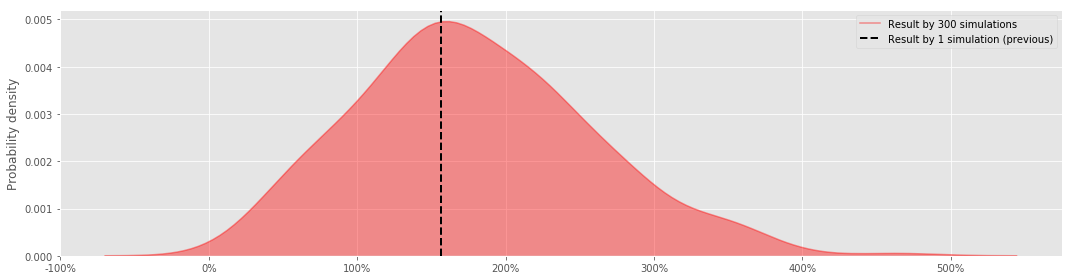

In [16]:
fmt = '%.0f%%'
xticks = mticks.FormatStrFormatter(fmt)

## PLOT KERNEL DENSITY DISTRIBUTION
fig, ax = plt.subplots(figsize=(15, 4))
sns.kdeplot(df_results['return'], shade=True, color='red', label=f'Result by {num_iter} simulations', alpha=0.4)
ax.xaxis.set_major_formatter(xticks)
ax.set_ylabel('Probability density')
ax.axvline(156.7, linestyle='--', color='k', linewidth=2, label='Result by 1 simulation (previous)')
plt.legend()
plt.tight_layout()
plt.show()

### WHAT ABOUT IN 2021?
After finalizing our study and preparing for our defence, we set out to see if how our trading models would perform in a new out-of-sample period being 2021. Therefore, we had to do a minor alteration to our signal generating function, as seen below.

In [18]:
## GENERATE TRADING SIGNALS
company_list = ['vestas', 'novo', 'maersk']
model_list = [1, 0, 1]
buy_list = [0, 0, 0]
variable_list = [3, 1, 1]
offset_list = [1, 10, 5]
n_components_list = [12, 9, 11]
df_index = pd.read_csv(f'data/index2021.csv', sep=';', decimal=',', index_col=0, parse_dates=True, dayfirst=True, encoding='utf-8', usecols=['date', 'index_return'])

## FOR EACH COMPANY
for select in [0, 1, 2]:
    
    ## INITIATE VARIABLES
    company = company_list[select]
    model_sel = model_list[select]
    buy_sell = buy_list[select]
    input_variables = variable_list[select]
    int_offset = offset_list[select]
    n_components_temp = n_components_list[select]

    signals = generate_signal2021(company, model_sel, buy_sell, input_variables, int_offset, n_components_temp, 0)
    
    if select == 0: df_signal = signals
    if select != 0: df_signal = df_signal.join(signals)
    if select == 2: df_signal = df_signal.join(df_index).fillna(1)

## SIMULATE TRADING STRATEGY
sign_MA = 20

df_signal_trade, time_in_market, amount = simulate_trading(df_signal, sign_MA)
df_signal_trade['portfolio'] = df_signal_trade['portfolio'] - 1
df_signal_trade['bah'] = df_signal_trade['bah'] - 1
df_signal_trade['index'] = df_signal_trade['index'] - 1
df_signal_trade.tail()

,vestas,vestas_return,novo,novo_return,maersk,maersk_return,index_return,portfolio,bah,index
date,,,,,,,,,,
2021-05-21,0.3,1.012495,0.25,0.984903,0.45,0.995906,1.011289,0.197684,0.138456,0.102830
2021-05-25,0.3,1.000851,0.20,0.997854,0.40,0.986201,1.003403,0.197684,0.132728,0.106583
2021-05-26,0.3,0.994473,0.15,0.985356,0.35,0.996130,0.999171,0.197684,0.123651,0.105666
2021-05-27,0.3,1.020949,0.10,1.003222,0.30,1.008069,0.989334,0.197684,0.135726,0.093873
2021-05-28,0.3,0.991625,0.05,0.997203,0.30,0.997925,1.013235,0.197684,0.130711,0.108350


As seen above, our portfolio yielded a return of 19.8% in 2021, compared to a BAH strategy obtaining 13.1% while the index of OMXC25GI rose by 10.8%.

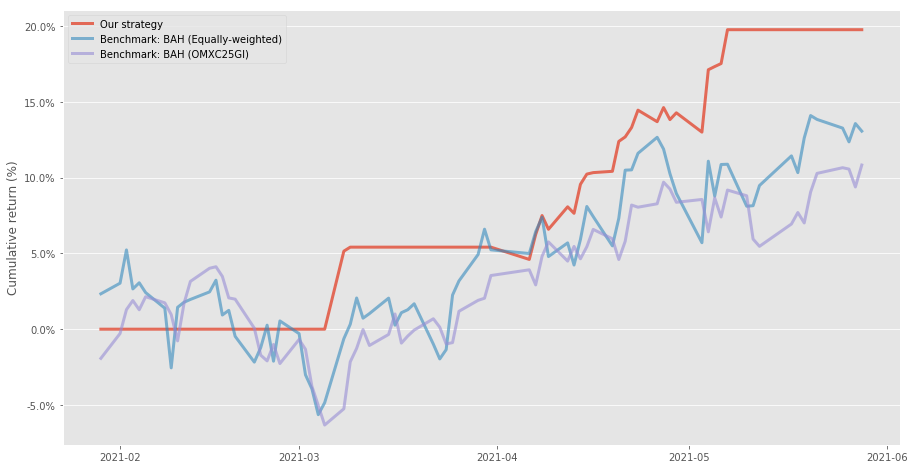

In [19]:
formatter2 = mdates.DateFormatter('%Y-%m')
locator2 = mdates.MonthLocator()

fig = plt.figure(figsize=(15, 8))
ax = plt.gca()
ax.xaxis.set_major_formatter(formatter2)
ax.xaxis.set_major_locator(locator2)
ax.plot(df_signal_trade.index, df_signal_trade['portfolio'], lw=3, label='Our strategy', alpha=0.8, zorder=1)
ax.plot(df_signal_trade.index, df_signal_trade['bah'], alpha=0.6, lw=3, label='Benchmark: BAH (Equally-weighted)', zorder=2)
ax.plot(df_signal_trade.index, df_signal_trade['index'], alpha=0.6, lw=3, label='Benchmark: BAH (OMXC25GI)', zorder=2)
ax.yaxis.set_major_formatter(mticks.PercentFormatter(1.0))
ax.set_ylabel('Cumulative return (%)')
ax.xaxis.grid()
plt.legend(loc='upper left')
plt.show()

This study contributes to the literature by investigating whether recent advances of NLP can lead to accurate firm-specific prediction models of return sign. We confirm the possibility of generating positive returns using firm-specific models in sparse settings, motivating further research in developing highly firm-specific NLP models. However, based on only one firm per industry, we cannot conclude definite differences between industries but motivate future research to study these differences.

DISCLAIMER: As put in our Thesis... 
> "We do not recommend using our prediction models for trading in practice, as robustness can be argued to be ambiguous. In addition, our trading results are purely theoretical as they do not incorporate practical aspects, such as transaction costs, liquidity concerns, and many more"